# imports

In [1]:
import pyodbc
import pandas as pd
import numpy as np
from arabic_reshaper import reshape
from bidi.algorithm import get_display
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from datetime import datetime, time
import seaborn as sns
import folium
from ortools.linear_solver import pywraplp
from sklearn.cluster import KMeans

# data 

# you need dataframes of 

### Ptoducts
### Orders
### Vehicle 
### WareHouse Stock Data

# data procces

In [5]:
final_factor_df = factor_df.drop(["BuyerLatitude", "BuyerLongitude"], axis=1).merge(
latlong_df[["BuyerID", "Latitude", "Longitude"]],
left_on="BuyerID",
right_on="BuyerID",
how="left"
)


final_factor_df = final_factor_df.merge(
    products_id_df[["ProductId", "Name"]],
    left_on="ProductId",
    right_on="ProductId",
    how="left"
)


final_factor_df = final_factor_df.merge(
    products_df[["ProductId", "LogisticCategoryName", "IsMeat", "IsFresh"]],
    left_on="ProductId",
    right_on="ProductId",
    how="left"
)


final_factor_df = final_factor_df.merge(
    products_df[["ProductId", "Weight", "Height", "Width", "Length"]],
    left_on="ProductId",
    right_on="ProductId",
    how="left"
)



final_factor_df = final_factor_df.merge(
    products_df[["ProductId","UnitId" ]],
    left_on="ProductId",
    right_on="ProductId",
    how="left"
)

final_factor_df = final_factor_df.merge(
    factor_df[['ProductId', 'TotalCount']],
    left_on="ProductId",
    right_on="ProductId",
    how="left"
)


final_factor_df["Product_volume"] = final_factor_df["Height"] * final_factor_df["Width"] * final_factor_df["Length"] * final_factor_df['TotalCount_x']
final_factor_df["Product_volume"] = final_factor_df["Product_volume"].astype(float)
final_factor_df["final_Weight"] = final_factor_df["Weight"] * final_factor_df['TotalCount_x']
final_factor_df["final_Weight"] = final_factor_df["final_Weight"].astype(float)




not_done = final_factor_df[final_factor_df['StatusId']!=2093]
stock = stock[stock['Quantity']!=0]

In [6]:
# stock_simple = stock[['ProductId', 'AvailableQuantity']]

# # ادغام بر اساس ProductId
# merged = not_done.merge(stock_simple, on='ProductId', how='left')

# # بررسی برای هر ردیف آیا قابل ارسال هست یا نه
# merged['CanSendRow'] = merged['AvailableQuantity'] >= merged['TotalCount_x']

# # حالا باید گروه‌بندی کنیم بر اساس فاکتور
# grouped = merged.groupby('AccountOrderShopResellerID')

# # فاکتورهایی که همه کالاهاشون `CanSendRow=True` هستن
# can_be_sent_ids = grouped['CanSendRow'].all()
# can_be_sent_ids = can_be_sent_ids[can_be_sent_ids].index  # فقط IDهایی که True هستن

# # فاکتورهایی که می‌تونن ارسال بشن
# can_be_sent = merged[merged['AccountOrderShopResellerID'].isin(can_be_sent_ids)]

# # فاکتورهایی که نمی‌تونن ارسال بشن
# cannot_be_sent = merged[~merged['AccountOrderShopResellerID'].isin(can_be_sent_ids)]

stock_simple = stock[['ProductId', 'AvailableQuantity']]

# ادغام بر اساس ProductId
merged = final_factor_df.merge(stock_simple, on='ProductId', how='left')

# بررسی برای هر ردیف آیا قابل ارسال هست یا نه
merged['CanSendRow'] = merged['AvailableQuantity'] >= merged['TotalCount_x']

# حالا باید گروه‌بندی کنیم بر اساس فاکتور
grouped = merged.groupby('AccountOrderShopResellerID')

# فاکتورهایی که همه کالاهاشون `CanSendRow=True` هستن
can_be_sent_ids = grouped['CanSendRow'].all()
can_be_sent_ids = can_be_sent_ids[can_be_sent_ids].index  # فقط IDهایی که True هستن

# فاکتورهایی که می‌تونن ارسال بشن
can_be_sent = merged[merged['AccountOrderShopResellerID'].isin(can_be_sent_ids)]

# فاکتورهایی که نمی‌تونن ارسال بشن
cannot_be_sent = merged[~merged['AccountOrderShopResellerID'].isin(can_be_sent_ids)]

can_be_sent = can_be_sent.merge(
latlong_df[["BuyerID",'Latitude', 'Longitude']],
left_on="BuyerID",
right_on="BuyerID",
how="left"
)

In [7]:
def create_invoice_summary(df):
    # تابع برای تعیین نوع فاکتور (عادی، فریزری، یخچالی یا میکس)
    def categorize_invoice(group):
        categories = set(group['LogisticCategoryName'].unique())
        if len(categories) == 1:
            return list(categories)[0]
        elif 'عادی' in categories and 'یخچالی (کول باکس)' in categories:
            return 'میکس عادی یخچالی (کول باکس)'
        elif 'عادی' in categories and 'فریزری' in categories:
            return 'میکس عادی فریزری'
        elif 'فریزری' in categories and 'یخچالی (کول باکس)' in categories:
            return 'میکس فریزری یخچالی (کول باکس)'

    # تجمیع فاکتورها
    summary = df.groupby(['AccountOrderShopResellerID', 'BuyerID', 'BuyerName']).apply(lambda x: pd.Series({
        'CategoryType': categorize_invoice(x),
        'TotalWeight': x['Weight'].sum(),
        'TotalVolume': x['Product_volume'].sum(),
        'NormalWeight': x.loc[x['LogisticCategoryName'] == 'عادی', 'Weight'].sum(),
        'NormalVolume': x.loc[x['LogisticCategoryName'] == 'عادی', 'Product_volume'].sum(),
        'FreezerWeight': x.loc[x['LogisticCategoryName'] == 'فریزری', 'Weight'].sum(),
        'FreezerVolume': x.loc[x['LogisticCategoryName'] == 'فریزری', 'Product_volume'].sum(),
        'CoolBoxWeight': x.loc[x['LogisticCategoryName'] == 'یخچالی (کول باکس)', 'Weight'].sum(),
        'CoolBoxVolume': x.loc[x['LogisticCategoryName'] == 'یخچالی (کول باکس)', 'Product_volume'].sum()
    })).reset_index()

    return summary

In [8]:
summary = create_invoice_summary(can_be_sent)
summary

C:\Users\Aliak\AppData\Local\Temp\ipykernel_25824\3057077386.py:15: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  summary = df.groupby(['AccountOrderShopResellerID', 'BuyerID', 'BuyerName']).apply(lambda x: pd.Series({


,AccountOrderShopResellerID,BuyerID,BuyerName,CategoryType,TotalWeight,TotalVolume,NormalWeight,NormalVolume,FreezerWeight,FreezerVolume,CoolBoxWeight,CoolBoxVolume
0,44855,5377,هتل جهان,عادی,3200.0,30000.0,3200.0,30000.0,0.0,0.0,0.0,0.0
1,44857,5377,هتل جهان,عادی,50.0,2496.0,50.0,2496.0,0.0,0.0,0.0,0.0
2,44858,1052,اسکان فرصت,عادی,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,44876,50,هتل اسکان الوند - شرکت ساخت هتل های خاطره خوش,عادی,700.0,15552.0,700.0,15552.0,0.0,0.0,0.0,0.0
4,44899,50,هتل اسکان الوند - شرکت ساخت هتل های خاطره خوش,عادی,3200.0,22500.0,3200.0,22500.0,0.0,0.0,0.0,0.0
5,44908,50,هتل اسکان الوند - شرکت ساخت هتل های خاطره خوش,عادی,1000.0,24000.0,1000.0,24000.0,0.0,0.0,0.0,0.0
6,44913,50,هتل اسکان الوند - شرکت ساخت هتل های خاطره خوش,عادی,27850.0,621900.0,27850.0,621900.0,0.0,0.0,0.0,0.0
7,44916,50,هتل اسکان الوند - شرکت ساخت هتل های خاطره خوش,عادی,20900.0,184960.0,20900.0,184960.0,0.0,0.0,0.0,0.0
8,44917,50,هتل اسکان الوند - شرکت ساخت هتل های خاطره خوش,عادی,16200.0,73728.0,16200.0,73728.0,0.0,0.0,0.0,0.0
9,44923,1052,اسکان فرصت,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
usl_table = summary[summary['CategoryType'].isin(['عادی', 'یخچالی (کول باکس)', 'میکس عادی یخچالی (کول باکس)'])]
friz_table = summary[summary['CategoryType'].isin(['فریزری', 'میکس فریزری یخچالی (کول باکس)'])]
usl_frezz_table = summary[summary['CategoryType'].isin(['میکس عادی فریزری'])]

usl_table = usl_table.merge(
latlong_df[["BuyerID",'Latitude', 'Longitude' ]],
left_on="BuyerID",
right_on="BuyerID",
how="left"
)

friz_table = friz_table.merge(
latlong_df[["BuyerID",'Latitude', 'Longitude' ]],
left_on="BuyerID",
right_on="BuyerID",
how="left"
)

usl_frezz_table = usl_frezz_table.merge(
latlong_df[["BuyerID",'Latitude', 'Longitude' ]],
left_on="BuyerID",
right_on="BuyerID",
how="left"
)

In [10]:
def json_default(obj):
    """تبدیل انواع داده‌های غیر JSON-serializable به فرمت مناسب"""
    if isinstance(obj, np.integer):
        return int(obj)
    if isinstance(obj, np.floating):
        return float(obj)
    if isinstance(obj, np.ndarray):
        return obj.tolist()
    raise TypeError(f"Object of type {obj.__class__.__name__} is not JSON serializable")

def clean_and_display_missing(df, name="DataFrame"):
    """حذف ردیف‌های با NaN در Latitude یا Longitude و گزارش داده‌های گم‌شده"""
    missing_coords = df[df['Latitude'].isna() | df['Longitude'].isna()]
    if not missing_coords.empty:
        print(f"Records with missing Latitude or Longitude in {name}:")
        print(missing_coords[['AccountOrderShopResellerID', 'BuyerName', 'Latitude', 'Longitude']])
    else:
        print(f"No records with missing coordinates in {name}.")
    cleaned_df = df.dropna(subset=['Latitude', 'Longitude'])
    print(f"{name} shape after cleaning: {cleaned_df.shape}")
    return cleaned_df

def scale_data(df):
    """مقیاس‌بندی وزن (گرم به کیلوگرم) و حجم (سانتی‌متر مکعب به متر مکعب)"""
    weight_columns = ['TotalWeight', 'NormalWeight', 'CoolBoxWeight', 'FreezerWeight']
    volume_columns = ['TotalVolume', 'NormalVolume', 'CoolBoxVolume', 'FreezerVolume']
    for col in weight_columns:
        if col in df.columns:
            df[col] = df[col] / 1000  # گرم به کیلوگرم
    for col in volume_columns:
        if col in df.columns:
            df[col] = df[col] / 1000000  # سانتی‌متر مکعب به متر مکعب
    return df

def fix_zero_volumes(df):
    """جایگزینی حجم‌های صفر با مقدار حداقل"""
    volume_columns = ['TotalVolume', 'NormalVolume', 'CoolBoxVolume', 'FreezerVolume']
    for col in volume_columns:
        if col in df.columns:
            df[col] = df[col].apply(lambda x: max(x, 0.001))
    return df

# clustring the usl factors 

In [11]:
def elbow_method(data, max_clusters=None, name="DataFrame"):
    """اجرای روش آرنج برای پیدا کردن تعداد بهینه خوشه‌ها"""
    if data.empty:
        print(f"Error: {name} is empty. Skipping Elbow Method.")
        return
    if data.shape[0] < 2:
        print(f"Error: {name} has fewer than 2 samples. Skipping Elbow Method.")
        return
    max_clusters = min(max_clusters or data.shape[0], data.shape[0], 10)  # حداکثر 10 خوشه
    if max_clusters < 1:
        print(f"Error: Not enough samples in {name} for clustering.")
        return
    distortions = []
    K = range(1, max_clusters + 1)
    for k in K:
        kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42)
        kmeans.fit(data)
        distortions.append(kmeans.inertia_)
    plt.figure(figsize=(10, 6))
    plt.plot(K, distortions, 'bx-')
    plt.xlabel('Number of clusters (K)')
    plt.ylabel('Distortion')
    plt.title(f'Elbow Method For Optimal K ({name})')
    plt.show()

def apply_clustering(data, n_clusters, name="DataFrame"):
    """اعمال خوشه‌بندی K-Means و اضافه کردن ستون Cluster"""
    if data.empty or data.shape[0] < 2:
        print(f"Warning: {name} is empty or has fewer than 2 samples. Setting Cluster=0.")
        data['Cluster'] = 0
        return data, None
    n_clusters = min(n_clusters, data.shape[0])
    if n_clusters < 1:
        print(f"Error: Not enough samples in {name} for clustering. Setting Cluster=0.")
        data['Cluster'] = 0
        return data, None
    kmeans = KMeans(n_clusters=n_clusters, init='k-means++', random_state=42)
    data['Cluster'] = kmeans.fit_predict(data[['Latitude', 'Longitude']]).astype(int)
    return data, kmeans

In [12]:
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
import json

# داده تست
X, _ = make_blobs(n_samples=300, centers=5, random_state=42)

inertias = []
k_range = range(1, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    inertias.append(kmeans.inertia_)

# خروجی به صورت JSON
elbow_data = {
    "k_values": list(k_range),
    "inertias": inertias
}

# چاپ خروجی JSON
print(json.dumps(elbow_data, indent=4))

# خروجی عددی - تشخیص elbow point (ساده‌شده)
def find_elbow(inertias):
    deltas = [inertias[i] - inertias[i+1] for i in range(len(inertias)-1)]
    second_deltas = [deltas[i] - deltas[i+1] for i in range(len(deltas)-1)]
    return second_deltas.index(max(second_deltas)) + 2  # چون index از 0 شروع میشه و k از 1

best_k = find_elbow(inertias)
print("Best k (Elbow point):", best_k)


{
    "k_values": [
        1,
        2,
        3,
        4,
        5,
        6,
        7,
        8,
        9,
        10
    ],
    "inertias": [
        17504.673093008787,
        9853.13441596323,
        2096.2619947645367,
        861.1580192160817,
        810.9852877676549,
        505.6429766858542,
        454.56250632959313,
        412.92584881460743,
        387.3145662015586,
        357.0933954291584
    ]
}
Best k (Elbow point): 3


No records with missing coordinates in usl_table.
usl_table shape after cleaning: (24, 14)
No records with missing coordinates in friz_table.
friz_table shape after cleaning: (0, 14)
No records with missing coordinates in usl_frezz_table.
usl_frezz_table shape after cleaning: (0, 14)


c:\Users\Aliak\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:1389: ConvergenceWarning: Number of distinct clusters (5) found smaller than n_clusters (6). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
c:\Users\Aliak\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:1389: ConvergenceWarning: Number of distinct clusters (5) found smaller than n_clusters (7). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
c:\Users\Aliak\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:1389: ConvergenceWarning: Number of distinct clusters (5) found smaller than n_clusters (8). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
c:\Users\Aliak\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:1389: ConvergenceWarning: Number of distinct clusters (5) found smaller than n_clusters (9). Possibly du

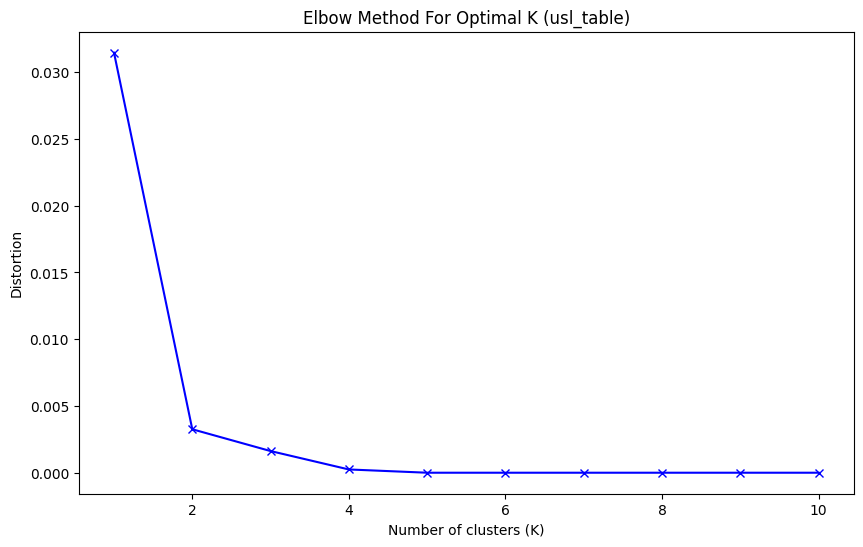

Error: friz_table is empty. Skipping Elbow Method.
Error: usl_frezz_table is empty. Skipping Elbow Method.
usl_table cluster distribution:
 Cluster
0    18
1     6
Name: count, dtype: int64
friz_table cluster distribution:
 Series([], Name: count, dtype: int64)


In [13]:
# تمیز کردن داده‌ها
usl_table = clean_and_display_missing(usl_table, "usl_table")
friz_table = clean_and_display_missing(friz_table, "friz_table")
usl_frezz_table = clean_and_display_missing(usl_frezz_table, "usl_frezz_table")

# مقیاس‌بندی وزن و حجم
usl_table = scale_data(usl_table)
friz_table = scale_data(friz_table)
usl_frezz_table = scale_data(usl_frezz_table)

# رفع حجم‌های صفر
usl_table = fix_zero_volumes(usl_table)
friz_table = fix_zero_volumes(friz_table)
usl_frezz_table = fix_zero_volumes(usl_frezz_table)

# اجرای Elbow Method
elbow_method(usl_table[['Latitude', 'Longitude']], name="usl_table")
elbow_method(friz_table[['Latitude', 'Longitude']], name="friz_table")
elbow_method(usl_frezz_table[['Latitude', 'Longitude']], name="usl_frezz_table")

# اعمال خوشه‌بندی
optimal_k = 2  # بر اساس نمودار آرنج تنظیم کن
usl_table, _ = apply_clustering(usl_table, optimal_k, "usl_table")
friz_table, _ = apply_clustering(friz_table, optimal_k, "friz_table")
usl_frezz_table, _ = apply_clustering(usl_frezz_table, optimal_k, "usl_frezz_table")

# فرض: usl_frezz_table = friz_table
friz_table = usl_frezz_table

# چاپ توزیع خوشه‌ها
print("usl_table cluster distribution:\n", usl_table['Cluster'].value_counts())
print("friz_table cluster distribution:\n", friz_table['Cluster'].value_counts())

# NanData

In [15]:
def NanDataPrint(table):
    invalid_orders = table[(table['TotalWeight'] == 0) | (table['TotalVolume'] == 0)]

        
    if not invalid_orders.empty:
        print("\nOrders with incomplete information (Weight or Volume = 0):")
        for _, row in invalid_orders.iterrows():
            print(f"  - Order ID: {row['AccountOrderShopResellerID']}, Buyer: {row['BuyerName']}, "
                    f"Weight: {row['TotalWeight']}, Volume: {row['TotalVolume']}")
    return  invalid_orders

In [16]:
def NanDataFilterd(table):
    table = table[(table['TotalWeight'] > 0) & (table['TotalVolume'] > 0)]
    return usl_table

In [17]:
usl_table = NanDataFilterd(usl_table)
invalid_orders = NanDataPrint(usl_table)


Orders with incomplete information (Weight or Volume = 0):
  - Order ID: 44858, Buyer: اسکان فرصت, Weight: 0.0, Volume: 0.001
  - Order ID: 44939, Buyer: هتل طوبی, Weight: 0.0, Volume: 0.001


# assignment

In [19]:
import pandas as pd
import numpy as np
from ortools.linear_solver import pywraplp
from datetime import datetime
import json

def json_default(obj):
    """تابع سفارشی برای مدیریت انواع غیرقابل سریالایز در JSON"""
    if isinstance(obj, np.integer):
        return int(obj)
    if isinstance(obj, np.floating):
        return float(obj)
    if isinstance(obj, np.ndarray):
        return obj.tolist()
    raise TypeError(f"Object of type {obj.__class__.__name__} is not JSON serializable")

def create_data_model(vehicles, df, is_mixed=False, mixed_type='normal'):
    data = {}
    if is_mixed:
        if mixed_type == 'normal':
            data['weights'] = list(df['NormalWeight'])
            data['volumes'] = list(df['NormalVolume'])
        elif mixed_type == 'coolbox':
            data['weights'] = list(df['CoolBoxWeight'])
            data['volumes'] = list(df['CoolBoxVolume'])
        elif mixed_type == 'friz':
            data['weights'] = list(df['FreezerWeight'])
            data['volumes'] = list(df['FreezerVolume'])
    else:
        data['weights'] = list(df['TotalWeight'])
        data['volumes'] = list(df['TotalVolume'])
    data['items'] = list(range(len(data['weights'])))
    data['item_ids'] = list(df['AccountOrderShopResellerID'].astype(int))
    data['bins'] = list(vehicles.index)
    data['capacities_weight'] = list(vehicles['MaxWeight'])
    data['capacities_volume'] = list(vehicles['Car_volume'])
    return data

def assign_vehicles_by_cluster(vehicles, df, is_mixed=False, mixed_type='normal', used_vehicles=None):
    vehicles = vehicles.copy()
    if 'RemainingWeight' not in vehicles.columns:
        vehicles['RemainingWeight'] = vehicles['MaxWeight']
        vehicles['RemainingVolume'] = vehicles['Car_volume']

    print(f"vehicles index: {list(vehicles.index)}")
    clusters = [int(x) for x in df['Cluster'].unique()]
    vehicle_assignments = {i: [] for i in vehicles.index}
    vehicle_used_weight = {i: 0 for i in vehicles.index}
    vehicle_used_volume = {i: 0 for i in vehicles.index}
    used_vehicles = used_vehicles or set()
    unassignable_orders = []
    unassigned_orders = []

    print(f"Initial vehicle_assignments keys: {list(vehicle_assignments.keys())}")

    max_weight = vehicles['RemainingWeight'].max()
    max_volume = vehicles['RemainingVolume'].max()
    if is_mixed:
        if mixed_type == 'normal':
            oversized_df = df[(df['NormalWeight'] > max_weight) | (df['NormalVolume'] > max_volume)]
            valid_df = df[(df['NormalWeight'] <= max_weight) & (df['NormalVolume'] <= max_volume)]
        elif mixed_type == 'coolbox':
            oversized_df = df[(df['CoolBoxWeight'] > max_weight) | (df['CoolBoxVolume'] > max_volume)]
            valid_df = df[(df['CoolBoxWeight'] <= max_weight) & (df['CoolBoxVolume'] <= max_volume)]
        elif mixed_type == 'friz':
            oversized_df = df[(df['FreezerWeight'] > max_weight) | (df['FreezerVolume'] > max_volume)]
            valid_df = df[(df['FreezerWeight'] <= max_weight) & (df['FreezerVolume'] <= max_volume)]
    else:
        oversized_df = df[(df['TotalWeight'] > max_weight) | (df['TotalVolume'] > max_volume)]
        valid_df = df[(df['TotalWeight'] <= max_weight) & (df['TotalVolume'] <= max_volume)]

    if not oversized_df.empty:
        print("\nUnassignable Orders (exceed maximum vehicle capacity):")
        for _, row in oversized_df.iterrows():
            print(f"  - Order ID: {row['AccountOrderShopResellerID']}, Buyer: {row['BuyerName']}, "
                  f"Weight: {row['NormalWeight' if is_mixed and mixed_type == 'normal' else 'CoolBoxWeight' if is_mixed and mixed_type == 'coolbox' else 'FreezerWeight' if is_mixed and mixed_type == 'friz' else 'TotalWeight']}, "
                  f"Volume: {row['NormalVolume' if is_mixed and mixed_type == 'normal' else 'CoolBoxVolume' if is_mixed and mixed_type == 'coolbox' else 'FreezerVolume' if is_mixed and mixed_type == 'friz' else 'TotalVolume']}, "
                  f"Cluster: {row['Cluster']}")
            unassignable_orders.append({
                'order_id': int(row['AccountOrderShopResellerID']),
                'buyer_name': str(row['BuyerName']),
                'category': mixed_type if is_mixed else 'normal',
                'weight': float(row['NormalWeight' if is_mixed and mixed_type == 'normal' else 'CoolBoxWeight' if is_mixed and mixed_type == 'coolbox' else 'FreezerWeight' if is_mixed and mixed_type == 'friz' else 'TotalWeight']),
                'volume': float(row['NormalVolume' if is_mixed and mixed_type == 'normal' else 'CoolBoxVolume' if is_mixed and mixed_type == 'coolbox' else 'FreezerVolume' if is_mixed and mixed_type == 'friz' else 'TotalVolume']),
                'cluster': int(row['Cluster']),
                'reason': 'Exceeds maximum vehicle capacity'
            })

    for cluster in clusters:
        print(f"\nAssigning vehicles for cluster {cluster}...")
        cluster_df = valid_df[valid_df['Cluster'] == cluster]
        if cluster_df.empty:
            print("No valid orders in this cluster.")
            continue

        data = create_data_model(vehicles, cluster_df, is_mixed, mixed_type)

        solver = pywraplp.Solver.CreateSolver("SCIP")
        if not solver:
            print("SCIP solver could not be created.")
            continue

        available_bins = [j for j in data['bins'] if j not in used_vehicles]
        print(f"Available bins for cluster {cluster}: {available_bins}")
        if not available_bins:
            print("No vehicles available for this cluster.")
            for _, row in cluster_df.iterrows():
                unassigned_orders.append({
                    'order_id': int(row['AccountOrderShopResellerID']),
                    'buyer_name': str(row['BuyerName']),
                    'category': mixed_type if is_mixed else 'normal',
                    'weight': float(row['NormalWeight' if is_mixed and mixed_type == 'normal' else 'CoolBoxWeight' if is_mixed and mixed_type == 'coolbox' else 'FreezerWeight' if is_mixed and mixed_type == 'friz' else 'TotalWeight']),
                    'volume': float(row['NormalVolume' if is_mixed and mixed_type == 'normal' else 'CoolBoxVolume' if is_mixed and mixed_type == 'coolbox' else 'FreezerVolume' if is_mixed and mixed_type == 'friz' else 'TotalVolume']),
                    'cluster': int(row['Cluster']),
                    'reason': 'No vehicles available in cluster'
                })
            continue

        x = {(i, j): solver.IntVar(0, 1, f"x_{i}_{j}") for i in data['items'] for j in available_bins}
        y = {j: solver.IntVar(0, 1, f"y_{j}") for j in available_bins}

        for i in data['items']:
            solver.Add(sum(x[i, j] for j in available_bins) <= 1)

        for j in available_bins:
            solver.Add(sum(x[i, j] * data['weights'][i] for i in data['items']) <= y[j] * data['capacities_weight'][available_bins.index(j)])
            solver.Add(sum(x[i, j] * data['volumes'][i] for i in data['items']) <= y[j] * data['capacities_volume'][available_bins.index(j)])

        solver.Add(sum(y[j] for j in available_bins) <= 1)  # فقط یک خودرو در هر خوشه

        objective = solver.Sum(x[i, j] for i in data['items'] for j in available_bins)
        solver.Maximize(objective)

        status = solver.Solve()

        if status == pywraplp.Solver.OPTIMAL or status == pywraplp.Solver.FEASIBLE:
            print(f"Solution found for cluster {cluster}.")
            for j in available_bins:
                if y[j].solution_value() > 0:
                    used_vehicles.add(j)
                    vehicle_name = str(vehicles.loc[j, 'Name'])
                    vehicle_plaque = str(vehicles.loc[j, 'Plaque'])
                    print(f"Vehicle {vehicle_name} (Plaque: {vehicle_plaque}, Weight Capacity: {vehicles.loc[j, 'RemainingWeight']}, "
                          f"Volume Capacity: {vehicles.loc[j, 'RemainingVolume']}) is used:")
                    current_vehicle_weight = 0
                    current_vehicle_volume = 0
                    for i in data['items']:
                        if x[i, j].solution_value() > 0:
                            row = cluster_df.iloc[i]
                            weight = float(data['weights'][i])
                            volume = float(data['volumes'][i])
                            vehicle_assignments[j].append({
                                'order_id': int(row['AccountOrderShopResellerID']),
                                'weight': weight,
                                'volume': volume,
                                'buyer_name': str(row['BuyerName']),
                                'location': {
                                    'latitude': float(row['Latitude']),
                                    'longitude': float(row['Longitude'])
                                },
                                'cluster': int(row['Cluster']),
                                'vehicle_name': vehicle_name,
                                'vehicle_plaque': vehicle_plaque
                            })
                            current_vehicle_weight += weight
                            current_vehicle_volume += volume
                            print(f"  - Order {row['AccountOrderShopResellerID']} (Weight: {weight}, Volume: {volume}, "
                                  f"Buyer: {row['BuyerName']}, Location: {row['Latitude']}, {row['Longitude']})")
                    vehicle_used_weight[j] += current_vehicle_weight
                    vehicle_used_volume[j] += current_vehicle_volume
                    vehicles.at[j, 'RemainingWeight'] -= current_vehicle_weight
                    vehicles.at[j, 'RemainingVolume'] -= current_vehicle_volume
                    break
            for i in data['items']:
                if sum(x[i, j].solution_value() for j in available_bins) == 0:
                    row = cluster_df.iloc[i]
                    unassigned_orders.append({
                        'order_id': int(row['AccountOrderShopResellerID']),
                        'buyer_name': str(row['BuyerName']),
                        'category': mixed_type if is_mixed else 'normal',
                        'weight': float(row['NormalWeight' if is_mixed and mixed_type == 'normal' else 'CoolBoxWeight' if is_mixed and mixed_type == 'coolbox' else 'FreezerWeight' if is_mixed and mixed_type == 'friz' else 'TotalWeight']),
                        'volume': float(row['NormalVolume' if is_mixed and mixed_type == 'normal' else 'CoolBoxVolume' if is_mixed and mixed_type == 'coolbox' else 'FreezerVolume' if is_mixed and mixed_type == 'friz' else 'TotalVolume']),
                        'cluster': int(row['Cluster']),
                        'reason': 'Could not be assigned in cluster'
                    })
        else:
            print(f"No feasible solution found for cluster {cluster}.")
            for _, row in cluster_df.iterrows():
                unassigned_orders.append({
                    'order_id': int(row['AccountOrderShopResellerID']),
                    'buyer_name': str(row['BuyerName']),
                    'category': mixed_type if is_mixed else 'normal',
                    'weight': float(row['NormalWeight' if is_mixed and mixed_type == 'normal' else 'CoolBoxWeight' if is_mixed and mixed_type == 'coolbox' else 'FreezerWeight' if is_mixed and mixed_type == 'friz' else 'TotalWeight']),
                    'volume': float(row['NormalVolume' if is_mixed and mixed_type == 'normal' else 'CoolBoxVolume' if is_mixed and mixed_type == 'coolbox' else 'FreezerVolume' if is_mixed and mixed_type == 'friz' else 'TotalVolume']),
                    'cluster': int(row['Cluster']),
                    'reason': 'No feasible solution found in cluster'
                })

    return vehicle_assignments, vehicles, unassignable_orders, unassigned_orders, used_vehicles
def assign_mixed_orders(usl_car, col_box, mixed_df):
    mixed_assignments = []
    mixed_unassignable = []
    mixed_unassigned = []

    normal_assignments, updated_usl_car, normal_unassignable, normal_unassigned, used_vehicles_usl = assign_vehicles_by_cluster(
        usl_car, mixed_df, is_mixed=True, mixed_type='normal', used_vehicles=set()
    )
    coolbox_assignments, updated_col_box, coolbox_unassignable, coolbox_unassigned, used_vehicles_col = assign_vehicles_by_cluster(
        col_box, mixed_df, is_mixed=True, mixed_type='coolbox', used_vehicles=set()
    )

    assigned_orders = set()
    for normal_vehicle_idx, normal_items in normal_assignments.items():
        for normal_item in normal_items:
            order_id = normal_item['order_id']
            if order_id in assigned_orders:
                continue
            for coolbox_vehicle_idx, coolbox_items in coolbox_assignments.items():
                for coolbox_item in coolbox_items:
                    if coolbox_item['order_id'] == order_id:
                        row = mixed_df[mixed_df['AccountOrderShopResellerID'] == order_id].iloc[0]
                        mixed_assignments.append({
                            'order_id': int(order_id),
                            'buyer_name': str(row['BuyerName']),
                            'normal_part': {
                                'weight': float(row['NormalWeight']),
                                'volume': float(row['NormalVolume']),
                                'vehicle': {
                                    'index': int(normal_vehicle_idx),
                                    'name': str(normal_item['vehicle_name']),
                                    'plaque': str(normal_item['vehicle_plaque'])
                                }
                            },
                            'coolbox_part': {
                                'weight': float(row['CoolBoxWeight']),
                                'volume': float(row['CoolBoxVolume']),
                                'vehicle': {
                                    'index': int(coolbox_vehicle_idx),
                                    'name': str(coolbox_item['vehicle_name']),
                                    'plaque': str(coolbox_item['vehicle_plaque'])
                                }
                            },
                            'location': {
                                'latitude': float(row['Latitude']),
                                'longitude': float(row['Longitude'])
                            },
                            'cluster': int(row['Cluster'])
                        })
                        assigned_orders.add(order_id)
                        break

    for order in normal_unassignable + coolbox_unassignable:
        if order['order_id'] not in assigned_orders:
            mixed_unassignable.append({
                'order_id': int(order['order_id']),
                'buyer_name': str(order['buyer_name']),
                'category': order['category'],
                'weight': float(order['weight']),
                'volume': float(order['volume']),
                'cluster': int(order['cluster']),
                'reason': order['reason']
            })
            assigned_orders.add(order['order_id'])

    for order in normal_unassigned + coolbox_unassigned:
        if order['order_id'] not in assigned_orders:
            row = mixed_df[mixed_df['AccountOrderShopResellerID'] == order['order_id']].iloc[0]
            mixed_unassigned.append({
                'order_id': int(order['order_id']),
                'buyer_name': str(row['BuyerName']),
                'category': 'mixed_normal_coolbox',
                'normal_weight': float(row['NormalWeight']),
                'normal_volume': float(row['NormalVolume']),
                'coolbox_weight': float(row['CoolBoxWeight']),
                'coolbox_volume': float(row['CoolBoxVolume']),
                'cluster': int(row['Cluster']),
                'reason': 'No suitable vehicle pair available for mixed normal-coolbox order'
            })
            assigned_orders.add(order['order_id'])

    for _, row in mixed_df.iterrows():
        order_id = int(row['AccountOrderShopResellerID'])
        if order_id not in assigned_orders:
            mixed_unassigned.append({
                'order_id': order_id,
                'buyer_name': str(row['BuyerName']),
                'category': 'mixed_normal_coolbox',
                'normal_weight': float(row['NormalWeight']),
                'normal_volume': float(row['NormalVolume']),
                'coolbox_weight': float(row['CoolBoxWeight']),
                'coolbox_volume': float(row['CoolBoxVolume']),
                'cluster': int(row['Cluster']),
                'reason': 'No suitable vehicle pair available for mixed normal-coolbox order'
            })

    return mixed_assignments, mixed_unassignable, mixed_unassigned, updated_usl_car, updated_col_box

def assign_mixed_friz_coolbox(friz_car, col_box, mixed_df):
    mixed_friz_assignments = []
    mixed_friz_unassignable = []
    mixed_friz_unassigned = []

    friz_assignments, updated_friz_car, friz_unassignable, friz_unassigned, used_vehicles_friz = assign_vehicles_by_cluster(
        friz_car, mixed_df, is_mixed=True, mixed_type='friz', used_vehicles=set()
    )
    coolbox_assignments, updated_col_box, coolbox_unassignable, coolbox_unassigned, used_vehicles_col = assign_vehicles_by_cluster(
        col_box, mixed_df, is_mixed=True, mixed_type='coolbox', used_vehicles=set()
    )

    assigned_orders = set()
    for friz_vehicle_idx, friz_items in friz_assignments.items():
        for friz_item in friz_items:
            order_id = friz_item['order_id']
            if order_id in assigned_orders:
                continue
            for coolbox_vehicle_idx, coolbox_items in coolbox_assignments.items():
                for coolbox_item in coolbox_items:
                    if coolbox_item['order_id'] == order_id:
                        row = mixed_df[mixed_df['AccountOrderShopResellerID'] == order_id].iloc[0]
                        mixed_friz_assignments.append({
                            'order_id': int(order_id),
                            'buyer_name': str(row['BuyerName']),
                            'friz_part': {
                                'weight': float(row['FreezerWeight']),
                                'volume': float(row['FreezerVolume']),
                                'vehicle': {
                                    'index': int(friz_vehicle_idx),
                                    'name': str(friz_item['vehicle_name']),
                                    'plaque': str(friz_item['vehicle_plaque'])
                                }
                            },
                            'coolbox_part': {
                                'weight': float(row['CoolBoxWeight']),
                                'volume': float(row['CoolBoxVolume']),
                                'vehicle': {
                                    'index': int(coolbox_vehicle_idx),
                                    'name': str(coolbox_item['vehicle_name']),
                                    'plaque': str(coolbox_item['vehicle_plaque'])
                                }
                            },
                            'location': {
                                'latitude': float(row['Latitude']),
                                'longitude': float(row['Longitude'])
                            },
                            'cluster': int(row['Cluster'])
                        })
                        assigned_orders.add(order_id)
                        break

    for order in friz_unassignable + coolbox_unassignable:
        if order['order_id'] not in assigned_orders:
            mixed_friz_unassignable.append({
                'order_id': int(order['order_id']),
                'buyer_name': str(order['buyer_name']),
                'category': order['category'],
                'weight': float(order['weight']),
                'volume': float(order['volume']),
                'cluster': int(order['cluster']),
                'reason': order['reason']
            })
            assigned_orders.add(order['order_id'])

    for order in friz_unassigned + coolbox_unassigned:
        if order['order_id'] not in assigned_orders:
            row = mixed_df[mixed_df['AccountOrderShopResellerID'] == order['order_id']].iloc[0]
            mixed_friz_unassigned.append({
                'order_id': int(order['order_id']),
                'buyer_name': str(row['BuyerName']),
                'category': 'mixed_friz_coolbox',
                'friz_weight': float(row['FreezerWeight']),
                'friz_volume': float(row['FreezerVolume']),
                'coolbox_weight': float(row['CoolBoxWeight']),
                'coolbox_volume': float(row['CoolBoxVolume']),
                'cluster': int(row['Cluster']),
                'reason': 'No suitable vehicle pair available for mixed friz-coolbox order'
            })
            assigned_orders.add(order['order_id'])

    for _, row in mixed_df.iterrows():
        order_id = int(row['AccountOrderShopResellerID'])
        if order_id not in assigned_orders:
            mixed_friz_unassigned.append({
                'order_id': order_id,
                'buyer_name': str(row['BuyerName']),
                'category': 'mixed_friz_coolbox',
                'friz_weight': float(row['FreezerWeight']),
                'friz_volume': float(row['FreezerVolume']),
                'coolbox_weight': float(row['CoolBoxWeight']),
                'coolbox_volume': float(row['CoolBoxVolume']),
                'cluster': int(row['Cluster']),
                'reason': 'No suitable vehicle pair available for mixed friz-coolbox order'
            })

    return mixed_friz_assignments, mixed_friz_unassignable, mixed_friz_unassigned, updated_friz_car, updated_col_box

def main():
    # آماده‌سازی داده‌ها
    used_vehicles_usl = set()
    used_vehicles_col = set()
    used_vehicles_friz = set()

    normal_df = usl_table[usl_table['CategoryType'] == 'عادی']
    coolbox_df = usl_table[usl_table['CategoryType'] == 'یخچالی (کول باکس)']
    mixed_df = usl_table[usl_table['CategoryType'] == 'میکس عادی یخچالی (کول باکس)']

    normal_assignments, updated_usl_car, normal_unassignable, normal_unassigned, used_vehicles_usl = assign_vehicles_by_cluster(
        usl_car, normal_df, used_vehicles=used_vehicles_usl
    )
    coolbox_assignments, updated_col_box, coolbox_unassignable, coolbox_unassigned, used_vehicles_col = assign_vehicles_by_cluster(
        col_box, coolbox_df, is_mixed=True, mixed_type='coolbox', used_vehicles=used_vehicles_col
    )
    mixed_assignments, mixed_unassignable, mixed_unassigned, updated_usl_car_mixed, updated_col_box_mixed = assign_mixed_orders(
        updated_usl_car, updated_col_box, mixed_df
    )

    friz_df = friz_table[friz_table['CategoryType'] == 'فریزی']
    coolbox_friz_df = friz_table[friz_table['CategoryType'] == 'کول‌باکس']
    mixed_friz_df = friz_table[friz_table['CategoryType'] == 'میکس فریزی-کول‌باکس']

    friz_assignments, updated_friz_car, friz_unassignable, friz_unassigned, used_vehicles_friz = assign_vehicles_by_cluster(
        friz_car, friz_df, is_mixed=True, mixed_type='friz', used_vehicles=used_vehicles_friz
    )
    coolbox_friz_assignments, updated_col_box_friz, coolbox_friz_unassignable, coolbox_friz_unassigned, used_vehicles_col = assign_vehicles_by_cluster(
        updated_col_box_mixed, coolbox_friz_df, is_mixed=True, mixed_type='coolbox', used_vehicles=used_vehicles_col
    )
    mixed_friz_assignments, mixed_friz_unassignable, mixed_friz_unassigned, updated_friz_car_mixed, updated_col_box_final = assign_mixed_friz_coolbox(
        updated_friz_car, updated_col_box_friz, mixed_friz_df
    )

    # محاسبه خلاصه
    total_orders = len(normal_df) + len(coolbox_df) + len(mixed_df) + len(friz_df) + len(coolbox_friz_df) + len(mixed_friz_df)
    allocated_orders = sum(len(orders) for orders in normal_assignments.values()) + \
                       sum(len(orders) for orders in coolbox_assignments.values()) + \
                       len(mixed_assignments) + \
                       sum(len(orders) for orders in friz_assignments.values()) + \
                       sum(len(orders) for orders in coolbox_friz_assignments.values()) + \
                       len(mixed_friz_assignments)
    unassigned_orders = len(normal_unassigned) + len(coolbox_unassigned) + len(mixed_unassigned) + \
                        len(friz_unassigned) + len(coolbox_friz_unassigned) + len(mixed_friz_unassigned)
    unassignable_orders = len(normal_unassignable) + len(coolbox_unassignable) + len(mixed_unassignable) + \
                          len(friz_unassignable) + len(coolbox_friz_unassignable) + len(mixed_friz_unassignable)
    clusters_processed = list(set(normal_df['Cluster'].unique()).union(
        coolbox_df['Cluster'].unique(), mixed_df['Cluster'].unique(),
        friz_df['Cluster'].unique(), coolbox_friz_df['Cluster'].unique(), mixed_friz_df['Cluster'].unique()
    ))
    clusters_processed = [int(x) for x in clusters_processed]

    # آماده‌سازی JSON
    normal_assignments_json = []
    for vehicle_idx, orders in normal_assignments.items():
        if orders:
            vehicle = updated_usl_car_mixed.loc[vehicle_idx]
            normal_assignments_json.append({
                'vehicle': {
                    'index': int(vehicle_idx),
                    'name': str(vehicle['Name']),
                    'plaque': str(vehicle['Plaque']),
                    'max_weight': float(vehicle['MaxWeight']),
                    'max_volume': float(vehicle['Car_volume']),
                    'remaining_weight': float(vehicle['RemainingWeight']),
                    'remaining_volume': float(vehicle['RemainingVolume'])
                },
                'orders': orders
            })

    coolbox_assignments_json = []
    for vehicle_idx, orders in coolbox_assignments.items():
        if orders:
            vehicle = updated_col_box.loc[vehicle_idx]
            coolbox_assignments_json.append({
                'vehicle': {
                    'index': int(vehicle_idx),
                    'name': str(vehicle['Name']),
                    'plaque': str(vehicle['Plaque']),
                    'max_weight': float(vehicle['MaxWeight']),
                    'max_volume': float(vehicle['Car_volume']),
                    'remaining_weight': float(vehicle['RemainingWeight']),
                    'remaining_volume': float(vehicle['RemainingVolume'])
                },
                'orders': orders
            })

    friz_assignments_json = []
    for vehicle_idx, orders in friz_assignments.items():
        if orders:
            vehicle = updated_friz_car.loc[vehicle_idx]
            friz_assignments_json.append({
                'vehicle': {
                    'index': int(vehicle_idx),
                    'name': str(vehicle['Name']),
                    'plaque': str(vehicle['Plaque']),
                    'max_weight': float(vehicle['MaxWeight']),
                    'max_volume': float(vehicle['Car_volume']),
                    'remaining_weight': float(vehicle['RemainingWeight']),
                    'remaining_volume': float(vehicle['RemainingVolume'])
                },
                'orders': orders
            })

    coolbox_friz_assignments_json = []
    for vehicle_idx, orders in coolbox_friz_assignments.items():
        if orders:
            vehicle = updated_col_box_friz.loc[vehicle_idx]
            coolbox_friz_assignments_json.append({
                'vehicle': {
                    'index': int(vehicle_idx),
                    'name': str(vehicle['Name']),
                    'plaque': str(vehicle['Plaque']),
                    'max_weight': float(vehicle['MaxWeight']),
                    'max_volume': float(vehicle['Car_volume']),
                    'remaining_weight': float(vehicle['RemainingWeight']),
                    'remaining_volume': float(vehicle['RemainingVolume'])
                },
                'orders': orders
            })

    # خروجی نهایی
    result = {
        'allocation_summary': {
            'allocation_date': datetime.now().strftime("%Y-%m-%d"),
            'total_orders': total_orders,
            'allocated_orders': allocated_orders,
            'unassigned_orders': unassigned_orders,
            'unassignable_orders': unassignable_orders,
            'clusters_processed': clusters_processed
        },
        'normal_assignments': normal_assignments_json,
        'coolbox_assignments': coolbox_assignments_json,
        'mixed_normal_coolbox_assignments': mixed_assignments,
        'friz_assignments': friz_assignments_json,
        'coolbox_friz_assignments': coolbox_friz_assignments_json,
        'mixed_friz_coolbox_assignments': mixed_friz_assignments,
        'unassignable_orders': normal_unassignable + coolbox_unassignable + mixed_unassignable +
                              friz_unassignable + coolbox_friz_unassignable + mixed_friz_unassignable,
        'unassigned_orders': normal_unassigned + coolbox_unassigned + mixed_unassigned +
                             friz_unassigned + coolbox_friz_unassigned + mixed_friz_unassigned
    }

    print("\nFinal Vehicle Assignments (Normal):", normal_assignments)
    print("\nUpdated usl_car DataFrame:\n", updated_usl_car_mixed[['Name', 'Plaque', 'MaxWeight', 'Car_volume', 'RemainingWeight', 'RemainingVolume']])
    print("\nUpdated col_box DataFrame:\n", updated_col_box_final[['Name', 'Plaque', 'MaxWeight', 'Car_volume', 'RemainingWeight', 'RemainingVolume']])
    print("\nUpdated friz_car DataFrame:\n", updated_friz_car_mixed[['Name', 'Plaque', 'MaxWeight', 'Car_volume', 'RemainingWeight', 'RemainingVolume']])
    print("\nJSON Output:")
    print(json.dumps(result, ensure_ascii=False, indent=2, default=json_default))

    return result, updated_usl_car_mixed, updated_col_box_final, updated_friz_car_mixed

if __name__ == "__main__":
    result, updated_usl_car, updated_col_box, updated_friz_car = main()

vehicles index: [0, 1, 2, 5, 6]
Initial vehicle_assignments keys: [0, 1, 2, 5, 6]

Assigning vehicles for cluster 0...
Available bins for cluster 0: [0, 1, 2, 5, 6]
Solution found for cluster 0.
Vehicle پراید وانت (Plaque: 58 ه 753 ایران 30, Weight Capacity: 600000.0, Volume Capacity: 2052372.0) is used:
  - Order 44855 (Weight: 3.2, Volume: 0.03, Buyer: هتل جهان, Location: 35.800608805095, 51.425477559450655)
  - Order 44857 (Weight: 0.05, Volume: 0.002496, Buyer: هتل جهان, Location: 35.800608805095, 51.425477559450655)
  - Order 44876 (Weight: 0.7, Volume: 0.015552, Buyer: هتل اسکان الوند - شرکت ساخت هتل های خاطره خوش, Location: 35.800608805095, 51.425477559450655)
  - Order 44899 (Weight: 3.2, Volume: 0.0225, Buyer: هتل اسکان الوند - شرکت ساخت هتل های خاطره خوش, Location: 35.800608805095, 51.425477559450655)
  - Order 44908 (Weight: 1.0, Volume: 0.024, Buyer: هتل اسکان الوند - شرکت ساخت هتل های خاطره خوش, Location: 35.800608805095, 51.425477559450655)
  - Order 44913 (Weight: 27.85,

In [20]:
import numpy as np
from scipy.spatial.distance import euclidean

# مختصات انبار
WAREHOUSE_COORDS = (35.73822816917282, 51.05946023574787)

def calculate_distance(coord1, coord2):
    """محاسبه فاصله اقلیدسی بین دو نقطه"""
    return euclidean(coord1, coord2)

def prioritize_destinations(assignments):
    """تابع اولویت‌بندی مقاصد برای هر خودرو بر اساس کمینه‌سازی مسافت"""
    prioritized_assignments = []
    
    for assignment in assignments:
        vehicle = assignment['vehicle']
        orders = assignment['orders']
        
        if not orders:
            prioritized_assignments.append(assignment)
            continue
        
        # مختصات تمام مقاصد
        coords = [(order['location']['latitude'], order['location']['longitude']) for order in orders]
        order_ids = [order['order_id'] for order in orders]
        
        # محاسبه فاصله از انبار به هر مقصد
        distances_from_warehouse = [(i, calculate_distance(WAREHOUSE_COORDS, coord)) for i, coord in enumerate(coords)]
        # پیدا کردن نزدیک‌ترین مقصد به انبار به‌عنوان نقطه شروع
        start_idx = min(distances_from_warehouse, key=lambda x: x[1])[0]
        
        # الگوریتم حریصانه برای مرتب‌سازی مقاصد
        visited = [False] * len(coords)
        visited[start_idx] = True
        route = [start_idx]
        current_idx = start_idx
        
        # انتخاب نزدیک‌ترین مقصد بعدی تا زمانی که همه مقاصد بازدید شوند
        while len(route) < len(coords):
            min_distance = float('inf')
            next_idx = None
            for i, coord in enumerate(coords):
                if not visited[i]:
                    dist = calculate_distance(coords[current_idx], coord)
                    if dist < min_distance:
                        min_distance = dist
                        next_idx = i
            if next_idx is not None:
                visited[next_idx] = True
                route.append(next_idx)
                current_idx = next_idx
        
        # افزودن اولویت به سفارشات
        prioritized_orders = []
        for priority, idx in enumerate(route, 1):
            order = orders[idx].copy()
            order['priority'] = priority
            prioritized_orders.append(order)
        
        prioritized_assignments.append({
            'vehicle': vehicle,
            'orders': prioritized_orders
        })
    
    return prioritized_assignments

def main_with_priority():
    # اجرای تابع اصلی برای دریافت تخصیص‌ها
    result, updated_usl_car, updated_col_box, updated_friz_car = main()
    
    # اعمال اولویت‌بندی به تخصیص‌های عادی
    result['normal_assignments'] = prioritize_destinations(result['normal_assignments'])
    # اعمال اولویت‌بندی به تخصیص‌های کول‌باکس
    result['coolbox_assignments'] = prioritize_destinations(result['coolbox_assignments'])
    # اعمال اولویت‌بندی به تخصیص‌های فریزی
    result['friz_assignments'] = prioritize_destinations(result['friz_assignments'])
    # اعمال اولویت‌بندی به تخصیص‌های کول‌باکس فریزی
    result['coolbox_friz_assignments'] = prioritize_destinations(result['coolbox_friz_assignments'])
    
    # برای سفارشات میکس (عادی-کول‌باکس و فریزی-کول‌باکس)، اولویت‌بندی بر اساس مختصات مقصد
    for mixed_type in ['mixed_normal_coolbox_assignments', 'mixed_friz_coolbox_assignments']:
        mixed_assignments = result[mixed_type]
        prioritized_mixed = []
        for assignment in mixed_assignments:
            order_id = assignment['order_id']
            location = (assignment['location']['latitude'], assignment['location']['longitude'])
            # محاسبه فاصله از انبار برای تعیین اولویت (ساده‌سازی برای میکس)
            distance = calculate_distance(WAREHOUSE_COORDS, location)
            prioritized_mixed.append((assignment, distance))
        
        # مرتب‌سازی بر اساس فاصله
        prioritized_mixed.sort(key=lambda x: x[1])
        result[mixed_type] = [item[0] | {'priority': i + 1} for i, item in enumerate(prioritized_mixed)]
    
    print("\nJSON Output with Priority:")
    print(json.dumps(result, ensure_ascii=False, indent=2, default=json_default))
    
    return result, updated_usl_car, updated_col_box, updated_friz_car

if __name__ == "__main__":
    result, updated_usl_car, updated_col_box, updated_friz_car = main_with_priority()

vehicles index: [0, 1, 2, 5, 6]
Initial vehicle_assignments keys: [0, 1, 2, 5, 6]

Assigning vehicles for cluster 0...
Available bins for cluster 0: [0, 1, 2, 5, 6]
Solution found for cluster 0.
Vehicle پراید وانت (Plaque: 58 ه 753 ایران 30, Weight Capacity: 600000.0, Volume Capacity: 2052372.0) is used:
  - Order 44855 (Weight: 3.2, Volume: 0.03, Buyer: هتل جهان, Location: 35.800608805095, 51.425477559450655)
  - Order 44857 (Weight: 0.05, Volume: 0.002496, Buyer: هتل جهان, Location: 35.800608805095, 51.425477559450655)
  - Order 44876 (Weight: 0.7, Volume: 0.015552, Buyer: هتل اسکان الوند - شرکت ساخت هتل های خاطره خوش, Location: 35.800608805095, 51.425477559450655)
  - Order 44899 (Weight: 3.2, Volume: 0.0225, Buyer: هتل اسکان الوند - شرکت ساخت هتل های خاطره خوش, Location: 35.800608805095, 51.425477559450655)
  - Order 44908 (Weight: 1.0, Volume: 0.024, Buyer: هتل اسکان الوند - شرکت ساخت هتل های خاطره خوش, Location: 35.800608805095, 51.425477559450655)
  - Order 44913 (Weight: 27.85,

In [21]:
import pandas as pd
import numpy as np
from ortools.linear_solver import pywraplp
from datetime import datetime
import json
from scipy.spatial.distance import euclidean

# مختصات انبار
WAREHOUSE_COORDS = (35.73822816917282, 51.05946023574787)

def json_default(obj):
    """تابع سفارشی برای مدیریت انواع غیرقابل سریالایز در JSON"""
    if isinstance(obj, np.integer):
        return int(obj)
    if isinstance(obj, np.floating):
        return float(obj)
    if isinstance(obj, np.ndarray):
        return obj.tolist()
    raise TypeError(f"Object of type {obj.__class__.__name__} is not JSON serializable")

def create_data_model(vehicles, df, is_mixed=False, mixed_type='normal'):
    data = {}
    if is_mixed:
        if mixed_type == 'normal':
            data['weights'] = list(df['NormalWeight'])
            data['volumes'] = list(df['NormalVolume'])
        elif mixed_type == 'coolbox':
            data['weights'] = list(df['CoolBoxWeight'])
            data['volumes'] = list(df['CoolBoxVolume'])
        elif mixed_type == 'friz':
            data['weights'] = list(df['FreezerWeight'])
            data['volumes'] = list(df['FreezerVolume'])
    else:
        data['weights'] = list(df['TotalWeight'])
        data['volumes'] = list(df['TotalVolume'])
    data['items'] = list(range(len(data['weights'])))
    data['item_ids'] = list(df['AccountOrderShopResellerID'].astype(int))
    data['bins'] = list(vehicles.index)
    data['capacities_weight'] = list(vehicles['MaxWeight'])
    data['capacities_volume'] = list(vehicles['Car_volume'])
    return data

def assign_vehicles_by_cluster(vehicles, df, is_mixed=False, mixed_type='normal', used_vehicles=None):
    if df.empty:
        vehicles = vehicles.copy()
        if 'RemainingWeight' not in vehicles.columns:
            vehicles['RemainingWeight'] = vehicles['MaxWeight']
            vehicles['RemainingVolume'] = vehicles['Car_volume']
        vehicle_assignments = {i: [] for i in vehicles.index}
        return vehicle_assignments, vehicles, [], [], used_vehicles or set()

    vehicles = vehicles.copy()
    if 'RemainingWeight' not in vehicles.columns:
        vehicles['RemainingWeight'] = vehicles['MaxWeight']
        vehicles['RemainingVolume'] = vehicles['Car_volume']

    clusters = [int(x) for x in df['Cluster'].unique()]
    vehicle_assignments = {i: [] for i in vehicles.index}
    vehicle_used_weight = {i: 0 for i in vehicles.index}
    vehicle_used_volume = {i: 0 for i in vehicles.index}
    used_vehicles = used_vehicles or set()
    unassignable_orders = []
    unassigned_orders = []

    max_weight = vehicles['RemainingWeight'].max()
    max_volume = vehicles['RemainingVolume'].max()
    if is_mixed:
        if mixed_type == 'normal':
            oversized_df = df[(df['NormalWeight'] > max_weight) | (df['NormalVolume'] > max_volume)]
            valid_df = df[(df['NormalWeight'] <= max_weight) & (df['NormalVolume'] <= max_volume)]
        elif mixed_type == 'coolbox':
            oversized_df = df[(df['CoolBoxWeight'] > max_weight) | (df['CoolBoxVolume'] > max_volume)]
            valid_df = df[(df['CoolBoxWeight'] <= max_weight) & (df['CoolBoxVolume'] <= max_volume)]
        elif mixed_type == 'friz':
            oversized_df = df[(df['FreezerWeight'] > max_weight) | (df['FreezerVolume'] > max_volume)]
            valid_df = df[(df['FreezerWeight'] <= max_weight) & (df['FreezerVolume'] <= max_volume)]
    else:
        oversized_df = df[(df['TotalWeight'] > max_weight) | (df['TotalVolume'] > max_volume)]
        valid_df = df[(df['TotalWeight'] <= max_weight) & (df['TotalVolume'] <= max_volume)]

    for _, row in oversized_df.iterrows():
        unassignable_orders.append({
            'order_id': int(row['AccountOrderShopResellerID']),
            'buyer_name': str(row['BuyerName']),
            'category': mixed_type if is_mixed else 'normal',
            'weight': float(row['NormalWeight' if is_mixed and mixed_type == 'normal' else 'CoolBoxWeight' if is_mixed and mixed_type == 'coolbox' else 'FreezerWeight' if is_mixed and mixed_type == 'friz' else 'TotalWeight']),
            'volume': float(row['NormalVolume' if is_mixed and mixed_type == 'normal' else 'CoolBoxVolume' if is_mixed and mixed_type == 'coolbox' else 'FreezerVolume' if is_mixed and mixed_type == 'friz' else 'TotalVolume']),
            'cluster': int(row['Cluster']),
            'reason': 'Exceeds maximum vehicle capacity'
        })

    for cluster in clusters:
        cluster_df = valid_df[valid_df['Cluster'] == cluster]
        if cluster_df.empty:
            continue

        data = create_data_model(vehicles, cluster_df, is_mixed, mixed_type)

        solver = pywraplp.Solver.CreateSolver("SCIP")
        if not solver:
            continue

        available_bins = [j for j in data['bins'] if j not in used_vehicles]
        if not available_bins:
            for _, row in cluster_df.iterrows():
                unassigned_orders.append({
                    'order_id': int(row['AccountOrderShopResellerID']),
                    'buyer_name': str(row['BuyerName']),
                    'category': mixed_type if is_mixed else 'normal',
                    'weight': float(row['NormalWeight' if is_mixed and mixed_type == 'normal' else 'CoolBoxWeight' if is_mixed and mixed_type == 'coolbox' else 'FreezerWeight' if is_mixed and mixed_type == 'friz' else 'TotalWeight']),
                    'volume': float(row['NormalVolume' if is_mixed and mixed_type == 'normal' else 'CoolBoxVolume' if is_mixed and mixed_type == 'coolbox' else 'FreezerVolume' if is_mixed and mixed_type == 'friz' else 'TotalVolume']),
                    'cluster': int(row['Cluster']),
                    'reason': 'No vehicles available in cluster'
                })
            continue

        x = {(i, j): solver.IntVar(0, 1, f"x_{i}_{j}") for i in data['items'] for j in available_bins}
        y = {j: solver.IntVar(0, 1, f"y_{j}") for j in available_bins}

        for i in data['items']:
            solver.Add(sum(x[i, j] for j in available_bins) <= 1)

        for j in available_bins:
            solver.Add(sum(x[i, j] * data['weights'][i] for i in data['items']) <= y[j] * data['capacities_weight'][available_bins.index(j)])
            solver.Add(sum(x[i, j] * data['volumes'][i] for i in data['items']) <= y[j] * data['capacities_volume'][available_bins.index(j)])

        solver.Add(sum(y[j] for j in available_bins) <= 1)

        objective = solver.Sum(x[i, j] for i in data['items'] for j in available_bins)
        solver.Maximize(objective)

        status = solver.Solve()

        if status == pywraplp.Solver.OPTIMAL or status == pywraplp.Solver.FEASIBLE:
            for j in available_bins:
                if y[j].solution_value() > 0:
                    used_vehicles.add(j)
                    vehicle_name = str(vehicles.loc[j, 'Name'])
                    vehicle_plaque = str(vehicles.loc[j, 'Plaque'])
                    current_vehicle_weight = 0
                    current_vehicle_volume = 0
                    for i in data['items']:
                        if x[i, j].solution_value() > 0:
                            row = cluster_df.iloc[i]
                            weight = float(data['weights'][i])
                            volume = float(data['volumes'][i])
                            vehicle_assignments[j].append({
                                'order_id': int(row['AccountOrderShopResellerID']),
                                'weight': weight,
                                'volume': volume,
                                'buyer_name': str(row['BuyerName']),
                                'location': {
                                    'latitude': float(row['Latitude']),
                                    'longitude': float(row['Longitude'])
                                },
                                'cluster': int(row['Cluster']),
                                'vehicle_name': vehicle_name,
                                'vehicle_plaque': vehicle_plaque
                            })
                            current_vehicle_weight += weight
                            current_vehicle_volume += volume
                    vehicles.at[j, 'RemainingWeight'] -= current_vehicle_weight
                    vehicles.at[j, 'RemainingVolume'] -= current_vehicle_volume
                    break
            for i in data['items']:
                if sum(x[i, j].solution_value() for j in available_bins) == 0:
                    row = cluster_df.iloc[i]
                    unassigned_orders.append({
                        'order_id': int(row['AccountOrderShopResellerID']),
                        'buyer_name': str(row['BuyerName']),
                        'category': mixed_type if is_mixed else 'normal',
                        'weight': float(row['NormalWeight' if is_mixed and mixed_type == 'normal' else 'CoolBoxWeight' if is_mixed and mixed_type == 'coolbox' else 'FreezerWeight' if is_mixed and mixed_type == 'friz' else 'TotalWeight']),
                        'volume': float(row['NormalVolume' if is_mixed and mixed_type == 'normal' else 'CoolBoxVolume' if is_mixed and mixed_type == 'coolbox' else 'FreezerVolume' if is_mixed and mixed_type == 'friz' else 'TotalVolume']),
                        'cluster': int(row['Cluster']),
                        'reason': 'Could not be assigned in cluster'
                    })
        else:
            for _, row in cluster_df.iterrows():
                unassigned_orders.append({
                    'order_id': int(row['AccountOrderShopResellerID']),
                    'buyer_name': str(row['BuyerName']),
                    'category': mixed_type if is_mixed else 'normal',
                    'weight': float(row['NormalWeight' if is_mixed and mixed_type == 'normal' else 'CoolBoxWeight' if is_mixed and mixed_type == 'coolbox' else 'FreezerWeight' if is_mixed and mixed_type == 'friz' else 'TotalWeight']),
                    'volume': float(row['NormalVolume' if is_mixed and mixed_type == 'normal' else 'CoolBoxVolume' if is_mixed and mixed_type == 'coolbox' else 'FreezerVolume' if is_mixed and mixed_type == 'friz' else 'TotalVolume']),
                    'cluster': int(row['Cluster']),
                    'reason': 'No feasible solution found in cluster'
                })

    return vehicle_assignments, vehicles, unassignable_orders, unassigned_orders, used_vehicles

def assign_mixed_orders(usl_car, col_box, mixed_df):
    if mixed_df.empty:
        return [], [], [], usl_car, col_box

    mixed_assignments = []
    mixed_unassignable = []
    mixed_unassigned = []

    normal_assignments, updated_usl_car, normal_unassignable, normal_unassigned, used_vehicles_usl = assign_vehicles_by_cluster(
        usl_car, mixed_df, is_mixed=True, mixed_type='normal', used_vehicles=set()
    )
    coolbox_assignments, updated_col_box, coolbox_unassignable, coolbox_unassigned, used_vehicles_col = assign_vehicles_by_cluster(
        col_box, mixed_df, is_mixed=True, mixed_type='coolbox', used_vehicles=set()
    )

    assigned_orders = set()
    for normal_vehicle_idx, normal_items in normal_assignments.items():
        for normal_item in normal_items:
            order_id = normal_item['order_id']
            if order_id in assigned_orders:
                continue
            for coolbox_vehicle_idx, coolbox_items in coolbox_assignments.items():
                for coolbox_item in coolbox_items:
                    if coolbox_item['order_id'] == order_id:
                        row = mixed_df[mixed_df['AccountOrderShopResellerID'] == order_id].iloc[0]
                        mixed_assignments.append({
                            'order_id': int(order_id),
                            'buyer_name': str(row['BuyerName']),
                            'normal_part': {
                                'weight': float(row['NormalWeight']),
                                'volume': float(row['NormalVolume']),
                                'vehicle': {
                                    'index': int(normal_vehicle_idx),
                                    'name': str(normal_item['vehicle_name']),
                                    'plaque': str(normal_item['vehicle_plaque'])
                                }
                            },
                            'coolbox_part': {
                                'weight': float(row['CoolBoxWeight']),
                                'volume': float(row['CoolBoxVolume']),
                                'vehicle': {
                                    'index': int(coolbox_vehicle_idx),
                                    'name': str(coolbox_item['vehicle_name']),
                                    'plaque': str(coolbox_item['vehicle_plaque'])
                                }
                            },
                            'location': {
                                'latitude': float(row['Latitude']),
                                'longitude': float(row['Longitude'])
                            },
                            'cluster': int(row['Cluster'])
                        })
                        assigned_orders.add(order_id)
                        break

    for order in normal_unassignable + coolbox_unassignable:
        if order['order_id'] not in assigned_orders:
            mixed_unassignable.append({
                'order_id': int(order['order_id']),
                'buyer_name': str(order['buyer_name']),
                'category': order['category'],
                'weight': float(order['weight']),
                'volume': float(order['volume']),
                'cluster': int(order['cluster']),
                'reason': order['reason']
            })
            assigned_orders.add(order['order_id'])

    for order in normal_unassigned + coolbox_unassigned:
        if order['order_id'] not in assigned_orders:
            row = mixed_df[mixed_df['AccountOrderShopResellerID'] == order['order_id']].iloc[0]
            mixed_unassigned.append({
                'order_id': int(order['order_id']),
                'buyer_name': str(row['BuyerName']),
                'category': 'mixed_normal_coolbox',
                'normal_weight': float(row['NormalWeight']),
                'normal_volume': float(row['NormalVolume']),
                'coolbox_weight': float(row['CoolBoxWeight']),
                'coolbox_volume': float(row['CoolBoxVolume']),
                'cluster': int(row['Cluster']),
                'reason': 'No suitable vehicle pair available for mixed normal-coolbox order'
            })
            assigned_orders.add(order['order_id'])

    for _, row in mixed_df.iterrows():
        order_id = int(row['AccountOrderShopResellerID'])
        if order_id not in assigned_orders:
            mixed_unassigned.append({
                'order_id': order_id,
                'buyer_name': str(row['BuyerName']),
                'category': 'mixed_normal_coolbox',
                'normal_weight': float(row['NormalWeight']),
                'normal_volume': float(row['NormalVolume']),
                'coolbox_weight': float(row['CoolBoxWeight']),
                'coolbox_volume': float(row['CoolBoxVolume']),
                'cluster': int(row['Cluster']),
                'reason': 'No suitable vehicle pair available for mixed normal-coolbox order'
            })

    return mixed_assignments, mixed_unassignable, mixed_unassigned, updated_usl_car, updated_col_box

def assign_mixed_friz_coolbox(friz_car, col_box, mixed_df):
    if mixed_df.empty:
        return [], [], [], friz_car, col_box

    mixed_friz_assignments = []
    mixed_friz_unassignable = []
    mixed_friz_unassigned = []

    friz_assignments, updated_friz_car, friz_unassignable, friz_unassigned, used_vehicles_friz = assign_vehicles_by_cluster(
        friz_car, mixed_df, is_mixed=True, mixed_type='friz', used_vehicles=set()
    )
    coolbox_assignments, updated_col_box, coolbox_unassignable, coolbox_unassigned, used_vehicles_col = assign_vehicles_by_cluster(
        col_box, mixed_df, is_mixed=True, mixed_type='coolbox', used_vehicles=set()
    )

    assigned_orders = set()
    for friz_vehicle_idx, friz_items in friz_assignments.items():
        for friz_item in friz_items:
            order_id = friz_item['order_id']
            if order_id in assigned_orders:
                continue
            for coolbox_vehicle_idx, coolbox_items in coolbox_assignments.items():
                for coolbox_item in coolbox_items:
                    if coolbox_item['order_id'] == order_id:
                        row = mixed_df[mixed_df['AccountOrderShopResellerID'] == order_id].iloc[0]
                        mixed_friz_assignments.append({
                            'order_id': int(order_id),
                            'buyer_name': str(row['BuyerName']),
                            'friz_part': {
                                'weight': float(row['FreezerWeight']),
                                'volume': float(row['FreezerVolume']),
                                'vehicle': {
                                    'index': int(friz_vehicle_idx),
                                    'name': str(friz_item['vehicle_name']),
                                    'plaque': str(friz_item['vehicle_plaque'])
                                }
                            },
                            'coolbox_part': {
                                'weight': float(row['CoolBoxWeight']),
                                'volume': float(row['CoolBoxVolume']),
                                'vehicle': {
                                    'index': int(coolbox_vehicle_idx),
                                    'name': str(coolbox_item['vehicle_name']),
                                    'plaque': str(coolbox_item['vehicle_plaque'])
                                }
                            },
                            'location': {
                                'latitude': float(row['Latitude']),
                                'longitude': float(row['Longitude'])
                            },
                            'cluster': int(row['Cluster'])
                        })
                        assigned_orders.add(order_id)
                        break

    for order in friz_unassignable + coolbox_unassignable:
        if order['order_id'] not in assigned_orders:
            mixed_friz_unassignable.append({
                'order_id': int(order['order_id']),
                'buyer_name': str(order['buyer_name']),
                'category': order['category'],
                'weight': float(order['weight']),
                'volume': float(order['volume']),
                'cluster': int(order['cluster']),
                'reason': order['reason']
            })
            assigned_orders.add(order['order_id'])

    for order in friz_unassigned + coolbox_unassigned:
        if order['order_id'] not in assigned_orders:
            row = mixed_df[mixed_df['AccountOrderShopResellerID'] == order['order_id']].iloc[0]
            mixed_friz_unassigned.append({
                'order_id': int(order['order_id']),
                'buyer_name': str(row['BuyerName']),
                'category': 'mixed_friz_coolbox',
                'friz_weight': float(row['FreezerWeight']),
                'friz_volume': float(row['FreezerVolume']),
                'coolbox_weight': float(row['CoolBoxWeight']),
                'coolbox_volume': float(row['CoolBoxVolume']),
                'cluster': int(row['Cluster']),
                'reason': 'No suitable vehicle pair available for mixed friz-coolbox order'
            })
            assigned_orders.add(order['order_id'])

    for _, row in mixed_df.iterrows():
        order_id = int(row['AccountOrderShopResellerID'])
        if order_id not in assigned_orders:
            mixed_friz_unassigned.append({
                'order_id': order_id,
                'buyer_name': str(row['BuyerName']),
                'category': 'mixed_friz_coolbox',
                'friz_weight': float(row['FreezerWeight']),
                'friz_volume': float(row['FreezerVolume']),
                'coolbox_weight': float(row['CoolBoxWeight']),
                'coolbox_volume': float(row['CoolBoxVolume']),
                'cluster': int(row['Cluster']),
                'reason': 'No suitable vehicle pair available for mixed friz-coolbox order'
            })

    return mixed_friz_assignments, mixed_friz_unassignable, mixed_friz_unassigned, updated_friz_car, updated_col_box

def calculate_distance(coord1, coord2):
    """محاسبه فاصله اقلیدسی بین دو نقطه"""
    return euclidean(coord1, coord2)

def prioritize_destinations(assignments):
    """تابع اولویت‌بندی مقاصد برای هر خودرو بر اساس کمینه‌سازی مسافت"""
    prioritized_assignments = []
    
    for assignment in assignments:
        vehicle = assignment['vehicle']
        orders = assignment['orders']
        
        if not orders:
            prioritized_assignments.append(assignment)
            continue
        
        # مختصات تمام مقاصد
        coords = [(order['location']['latitude'], order['location']['longitude']) for order in orders]
        order_ids = [order['order_id'] for order in orders]
        
        # محاسبه فاصله از انبار به هر مقصد
        distances_from_warehouse = [(i, calculate_distance(WAREHOUSE_COORDS, coord)) for i, coord in enumerate(coords)]
        # پیدا کردن نزدیک‌ترین مقصد به انبار به‌عنوان نقطه شروع
        start_idx = min(distances_from_warehouse, key=lambda x: x[1])[0]
        
        # الگوریتم حریصانه برای مرتب‌سازی مقاصد
        visited = [False] * len(coords)
        visited[start_idx] = True
        route = [start_idx]
        current_idx = start_idx
        
        # انتخاب نزدیک‌ترین مقصد بعدی تا زمانی که همه مقاصد بازدید شوند
        while len(route) < len(coords):
            min_distance = float('inf')
            next_idx = None
            for i, coord in enumerate(coords):
                if not visited[i]:
                    dist = calculate_distance(coords[current_idx], coord)
                    if dist < min_distance:
                        min_distance = dist
                        next_idx = i
            if next_idx is not None:
                visited[next_idx] = True
                route.append(next_idx)
                current_idx = next_idx
        
        # افزودن اولویت به سفارشات
        prioritized_orders = []
        for priority, idx in enumerate(route, 1):
            order = orders[idx].copy()
            order['priority'] = priority
            prioritized_orders.append(order)
        
        prioritized_assignments.append({
            'vehicle': vehicle,
            'orders': prioritized_orders
        })
    
    return prioritized_assignments

def main():
    used_vehicles_usl = set()
    used_vehicles_col = set()
    used_vehicles_friz = set()

    normal_df = usl_table[usl_table['CategoryType'] == 'عادی'] if 'usl_table' in globals() else pd.DataFrame()
    coolbox_df = usl_table[usl_table['CategoryType'] == 'یخچالی (کول باکس)'] if 'usl_table' in globals() else pd.DataFrame()
    mixed_df = usl_table[usl_table['CategoryType'] == 'میکس عادی یخچالی (کول باکس)'] if 'usl_table' in globals() else pd.DataFrame()
    friz_df = friz_table[friz_table['CategoryType'] == 'فریزی'] if 'friz_table' in globals() else pd.DataFrame()
    coolbox_friz_df = friz_table[friz_table['CategoryType'] == 'کول‌باکس'] if 'friz_table' in globals() else pd.DataFrame()
    mixed_friz_df = friz_table[friz_table['CategoryType'] == 'میکس فریزی-کول‌باکس'] if 'friz_table' in globals() else pd.DataFrame()

    normal_assignments = {}
    updated_usl_car = usl_car.copy() if 'usl_car' in globals() else pd.DataFrame()
    normal_unassignable = []
    normal_unassigned = []
    if not normal_df.empty:
        normal_assignments, updated_usl_car, normal_unassignable, normal_unassigned, used_vehicles_usl = assign_vehicles_by_cluster(
            usl_car, normal_df, used_vehicles=used_vehicles_usl
        )

    coolbox_assignments = {}
    updated_col_box = col_box.copy() if 'col_box' in globals() else pd.DataFrame()
    coolbox_unassignable = []
    coolbox_unassigned = []
    if not coolbox_df.empty:
        coolbox_assignments, updated_col_box, coolbox_unassignable, coolbox_unassigned, used_vehicles_col = assign_vehicles_by_cluster(
            col_box, coolbox_df, is_mixed=True, mixed_type='coolbox', used_vehicles=used_vehicles_col
        )

    mixed_assignments = []
    mixed_unassignable = []
    mixed_unassigned = []
    if not mixed_df.empty:
        mixed_assignments, mixed_unassignable, mixed_unassigned, updated_usl_car_mixed, updated_col_box_mixed = assign_mixed_orders(
            updated_usl_car, updated_col_box, mixed_df
        )
    else:
        updated_usl_car_mixed = updated_usl_car
        updated_col_box_mixed = updated_col_box

    friz_assignments = {}
    updated_friz_car = friz_car.copy() if 'friz_car' in globals() else pd.DataFrame()
    friz_unassignable = []
    friz_unassigned = []
    if not friz_df.empty:
        friz_assignments, updated_friz_car, friz_unassignable, friz_unassigned, used_vehicles_friz = assign_vehicles_by_cluster(
            friz_car, friz_df, is_mixed=True, mixed_type='friz', used_vehicles=used_vehicles_friz
        )

    coolbox_friz_assignments = {}
    coolbox_friz_unassignable = []
    coolbox_friz_unassigned = []
    if not coolbox_friz_df.empty:
        coolbox_friz_assignments, updated_col_box_friz, coolbox_friz_unassignable, coolbox_friz_unassigned, used_vehicles_col = assign_vehicles_by_cluster(
            updated_col_box_mixed, coolbox_friz_df, is_mixed=True, mixed_type='coolbox', used_vehicles=used_vehicles_col
        )
    else:
        updated_col_box_friz = updated_col_box_mixed

    mixed_friz_assignments = []
    mixed_friz_unassignable = []
    mixed_friz_unassigned = []
    if not mixed_friz_df.empty:
        mixed_friz_assignments, mixed_friz_unassignable, mixed_friz_unassigned, updated_friz_car_mixed, updated_col_box_final = assign_mixed_friz_coolbox(
            updated_friz_car, updated_col_box_friz, mixed_friz_df
        )
    else:
        updated_friz_car_mixed = updated_friz_car
        updated_col_box_final = updated_col_box_friz

    total_orders = len(normal_df) + len(coolbox_df) + len(mixed_df) + len(friz_df) + len(coolbox_friz_df) + len(mixed_friz_df)
    allocated_orders = sum(len(orders) for orders in normal_assignments.values()) + \
                       sum(len(orders) for orders in coolbox_assignments.values()) + \
                       len(mixed_assignments) + \
                       sum(len(orders) for orders in friz_assignments.values()) + \
                       sum(len(orders) for orders in coolbox_friz_assignments.values()) + \
                       len(mixed_friz_assignments)
    unassigned_orders = len(normal_unassigned) + len(coolbox_unassigned) + len(mixed_unassigned) + \
                        len(friz_unassigned) + len(coolbox_friz_unassigned) + len(mixed_friz_unassigned)
    unassignable_orders = len(normal_unassignable) + len(coolbox_unassignable) + len(mixed_unassignable) + \
                          len(friz_unassignable) + len(coolbox_friz_unassignable) + len(mixed_friz_unassignable)
    clusters_processed = list(set(normal_df['Cluster'].unique()).union(
        coolbox_df['Cluster'].unique(), mixed_df['Cluster'].unique(),
        friz_df['Cluster'].unique(), coolbox_friz_df['Cluster'].unique(), mixed_friz_df['Cluster'].unique()
    ))
    clusters_processed = [int(x) for x in clusters_processed]

    normal_assignments_json = []
    for vehicle_idx, orders in normal_assignments.items():
        if orders:
            vehicle = updated_usl_car_mixed.loc[vehicle_idx]
            normal_assignments_json.append({
                'vehicle': {
                    'index': int(vehicle_idx),
                    'name': str(vehicle['Name']),
                    'plaque': str(vehicle['Plaque']),
                    'max_weight': float(vehicle['MaxWeight']),
                    'max_volume': float(vehicle['Car_volume']),
                    'remaining_weight': float(vehicle['RemainingWeight']),
                    'remaining_volume': float(vehicle['RemainingVolume'])
                },
                'orders': orders
            })

    coolbox_assignments_json = []
    for vehicle_idx, orders in coolbox_assignments.items():
        if orders:
            vehicle = updated_col_box.loc[vehicle_idx]
            coolbox_assignments_json.append({
                'vehicle': {
                    'index': int(vehicle_idx),
                    'name': str(vehicle['Name']),
                    'plaque': str(vehicle['Plaque']),
                    'max_weight': float(vehicle['MaxWeight']),
                    'max_volume': float(vehicle['Car_volume']),
                    'remaining_weight': float(vehicle['RemainingWeight']),
                    'remaining_volume': float(vehicle['RemainingVolume'])
                },
                'orders': orders
            })

    friz_assignments_json = []
    for vehicle_idx, orders in friz_assignments.items():
        if orders:
            vehicle = updated_friz_car.loc[vehicle_idx]
            friz_assignments_json.append({
                'vehicle': {
                    'index': int(vehicle_idx),
                    'name': str(vehicle['Name']),
                    'plaque': str(vehicle['Plaque']),
                    'max_weight': float(vehicle['MaxWeight']),
                    'max_volume': float(vehicle['Car_volume']),
                    'remaining_weight': float(vehicle['RemainingWeight']),
                    'remaining_volume': float(vehicle['RemainingVolume'])
                },
                'orders': orders
            })

    coolbox_friz_assignments_json = []
    for vehicle_idx, orders in coolbox_friz_assignments.items():
        if orders:
            vehicle = updated_col_box_friz.loc[vehicle_idx]
            coolbox_friz_assignments_json.append({
                'vehicle': {
                    'index': int(vehicle_idx),
                    'name': str(vehicle['Name']),
                    'plaque': str(vehicle['Plaque']),
                    'max_weight': float(vehicle['MaxWeight']),
                    'max_volume': float(vehicle['Car_volume']),
                    'remaining_weight': float(vehicle['RemainingWeight']),
                    'remaining_volume': float(vehicle['RemainingVolume'])
                },
                'orders': orders
            })

    result = {
        'allocation_summary': {
            'allocation_date': datetime.now().strftime("%Y-%m-%d"),
            'total_orders': total_orders,
            'allocated_orders': allocated_orders,
            'unassigned_orders': unassigned_orders,
            'unassignable_orders': unassignable_orders,
            'clusters_processed': clusters_processed
        },
        'normal_assignments': normal_assignments_json,
        'coolbox_assignments': coolbox_assignments_json,
        'mixed_normal_coolbox_assignments': mixed_assignments,
        'friz_assignments': friz_assignments_json,
        'coolbox_friz_assignments': coolbox_friz_assignments_json,
        'mixed_friz_coolbox_assignments': mixed_friz_assignments,
        'unassignable_orders': normal_unassignable + coolbox_unassignable + mixed_unassignable +
                              friz_unassignable + coolbox_friz_unassignable + mixed_friz_unassignable,
        'unassigned_orders': normal_unassigned + coolbox_unassigned + mixed_unassigned +
                             friz_unassigned + coolbox_friz_unassigned + mixed_friz_unassigned
    }

    return result, updated_usl_car_mixed, updated_col_box_final, updated_friz_car_mixed

def main_with_priority():
    # اجرای تابع اصلی برای دریافت تخصیص‌ها
    result, updated_usl_car, updated_col_box, updated_friz_car = main()
    
    # اعمال اولویت‌بندی به تخصیص‌های عادی
    result['normal_assignments'] = prioritize_destinations(result['normal_assignments'])
    # اعمال اولویت‌بندی به تخصیص‌های کول‌باکس
    result['coolbox_assignments'] = prioritize_destinations(result['coolbox_assignments'])
    # اعمال اولویت‌بندی به تخصیص‌های فریزی
    result['friz_assignments'] = prioritize_destinations(result['friz_assignments'])
    # اعمال اولویت‌بندی به تخصیص‌های کول‌باکس فریزی
    result['coolbox_friz_assignments'] = prioritize_destinations(result['coolbox_friz_assignments'])
    
    # برای سفارشات میکس (عادی-کول‌باکس و فریزی-کول‌باکس)، اولویت‌بندی بر اساس مختصات مقصد
    for mixed_type in ['mixed_normal_coolbox_assignments', 'mixed_friz_coolbox_assignments']:
        mixed_assignments = result[mixed_type]
        prioritized_mixed = []
        for assignment in mixed_assignments:
            order_id = assignment['order_id']
            location = (assignment['location']['latitude'], assignment['location']['longitude'])
            # محاسبه فاصله از انبار برای تعیین اولویت (ساده‌سازی برای میکس)
            distance = calculate_distance(WAREHOUSE_COORDS, location)
            prioritized_mixed.append((assignment, distance))
        
        # مرتب‌سازی بر اساس فاصله
        prioritized_mixed.sort(key=lambda x: x[1])
        result[mixed_type] = [item[0] | {'priority': i + 1} for i, item in enumerate(prioritized_mixed)]
    
    print("\nJSON Output with Priority:")
    print(json.dumps(result, ensure_ascii=False, indent=2, default=json_default))
    
    return result, updated_usl_car, updated_col_box, updated_friz_car

if __name__ == "__main__":
    result, updated_usl_car, updated_col_box, updated_friz_car = main_with_priority()


JSON Output with Priority:
{
  "allocation_summary": {
    "allocation_date": "2025-05-31",
    "total_orders": 24,
    "allocated_orders": 24,
    "unassigned_orders": 0,
    "unassignable_orders": 0,
    "clusters_processed": [
      0,
      1
    ]
  },
  "normal_assignments": [
    {
      "vehicle": {
        "index": 0,
        "name": "پراید وانت",
        "plaque": "58 ه 753 ایران 30",
        "max_weight": 600000.0,
        "max_volume": 2052372.0,
        "remaining_weight": 599890.4,
        "remaining_volume": 2052370.814554
      },
      "orders": [
        {
          "order_id": 44943,
          "weight": 6.45,
          "volume": 0.045,
          "buyer_name": "رستوران زلال",
          "location": {
            "latitude": 35.76765946926171,
            "longitude": 51.426186873802585
          },
          "cluster": 0,
          "vehicle_name": "پراید وانت",
          "vehicle_plaque": "58 ه 753 ایران 30",
          "priority": 1
        },
        {
          "ord